In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
import timeit
import math

### Data Overview 

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)

(250000, 102)


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Columns: 102 entries, id to loss
dtypes: float64(95), int64(7)
memory usage: 194.5 MB
None


In [4]:
print(df.isnull().sum())

id      0
f0      0
f1      0
f2      0
f3      0
       ..
f96     0
f97     0
f98     0
f99     0
loss    0
Length: 102, dtype: int64


In [5]:
abs_corr_features = df.corr().abs()

rearrange = (abs_corr_features.where(np.triu(np.ones(abs_corr_features.shape), k=1)
                                     .astype(np.bool)).stack().sort_values(ascending=False))

In [6]:
print(rearrange)

f9   f42     3.400753e-02
f25  f30     3.269396e-02
f14  f64     3.237743e-02
f9   f62     3.031523e-02
f25  loss    3.016408e-02
                 ...     
f20  f88     9.782137e-06
f39  f67     8.436416e-06
f9   f45     6.441937e-06
f28  f71     5.733725e-06
f82  f95     7.268687e-07
Length: 5151, dtype: float64


In [7]:
df.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f91,f92,f93,f94,f95,f96,f97,f98,f99,loss
0,0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,...,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980,15
1,1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,...,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383,3
2,2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,...,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550,6
3,3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,...,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880,2
4,4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,...,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002995CF81D08>,
      dtype=object)

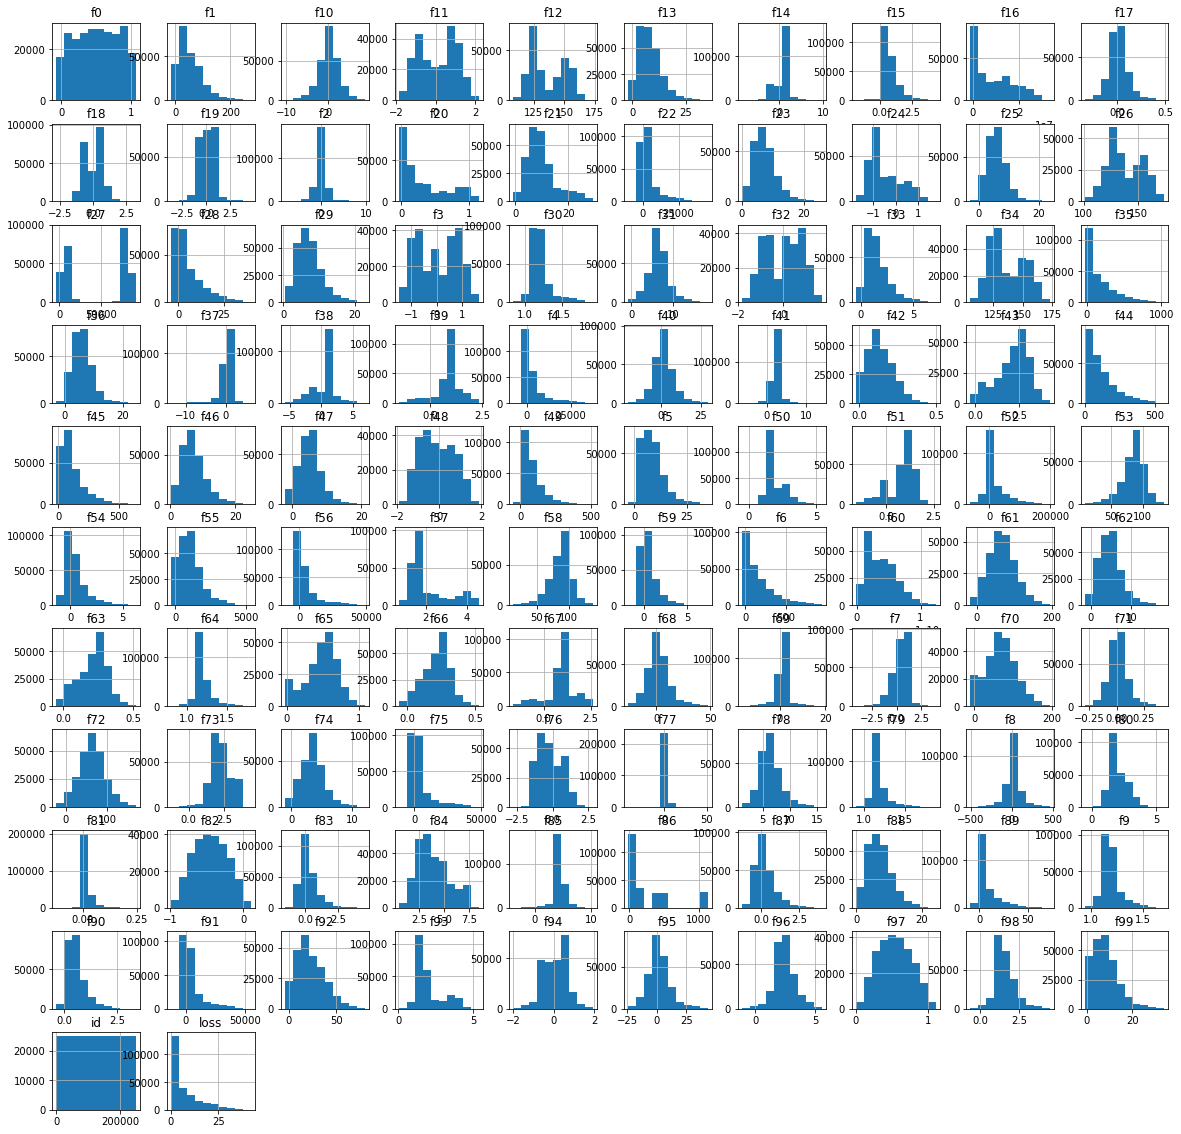

In [8]:
df.hist(figsize=(20,20))

In [8]:
y = df['loss']
print(y.size)

250000


In [9]:
y = y.to_numpy()

In [10]:
X = df.loc[:, df.columns != 'loss']
X = X.loc[:, X.columns != 'id']
X.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99
0,-0.002350,59,0.766739,-1.350460,42.2727,16.68570,30.3599,1.267300,0.392007,1.09101,...,0.376622,-42.43990,26.854000,1.45751,0.696161,0.941764,1.828470,0.924090,2.29658,10.48980
1,0.784462,145,-0.463845,-0.530421,27324.9000,3.47545,160.4980,0.828007,3.735860,1.28138,...,0.147973,-184.13200,7.901370,1.70644,-0.494699,-2.058300,0.819184,0.439152,2.36470,1.14383
2,0.317816,19,-0.432571,-0.382644,1383.2600,19.71290,31.1026,-0.515354,34.430800,1.24210,...,0.335985,7.43721,37.218100,3.25339,0.337934,0.615037,2.216760,0.745268,1.69679,12.30550
3,0.210753,17,-0.616454,0.946362,-119.2530,4.08235,185.2570,1.383310,-47.521400,1.09130,...,0.336490,9.66778,0.626942,1.49425,0.517513,-10.222100,2.627310,0.617270,1.45645,10.02880
4,0.439671,20,0.968126,-0.092546,74.3020,12.30650,72.1860,-0.233964,24.399100,1.10151,...,0.528518,290.65700,15.604300,1.73557,-0.476668,1.390190,2.195740,0.826987,1.78485,7.07197


In [11]:
print(X.shape)

(250000, 100)


In [12]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
print(X)

[[-1.66804452  0.17976755  0.49885428 ...  1.70619955  1.11353082
   0.43223676]
 [ 0.88751038  2.20823445 -0.43185734 ... -0.43396798  1.21893008
  -1.22269152]
 [-0.62814998 -0.76370543 -0.40820428 ...  0.91700786  0.18550057
   0.75375002]
 ...
 [-1.51093089  0.0382466   0.26902769 ...  1.29330624 -0.88415027
  -1.34460661]
 [ 1.51394323 -0.9288132  -0.83953868 ...  0.70588534 -0.9508727
  -0.11207278]
 [-0.86714664 -0.00892705  0.47054155 ... -0.37498889 -0.99254966
   3.69436478]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029960ACA3C8>,
      dtype=object)

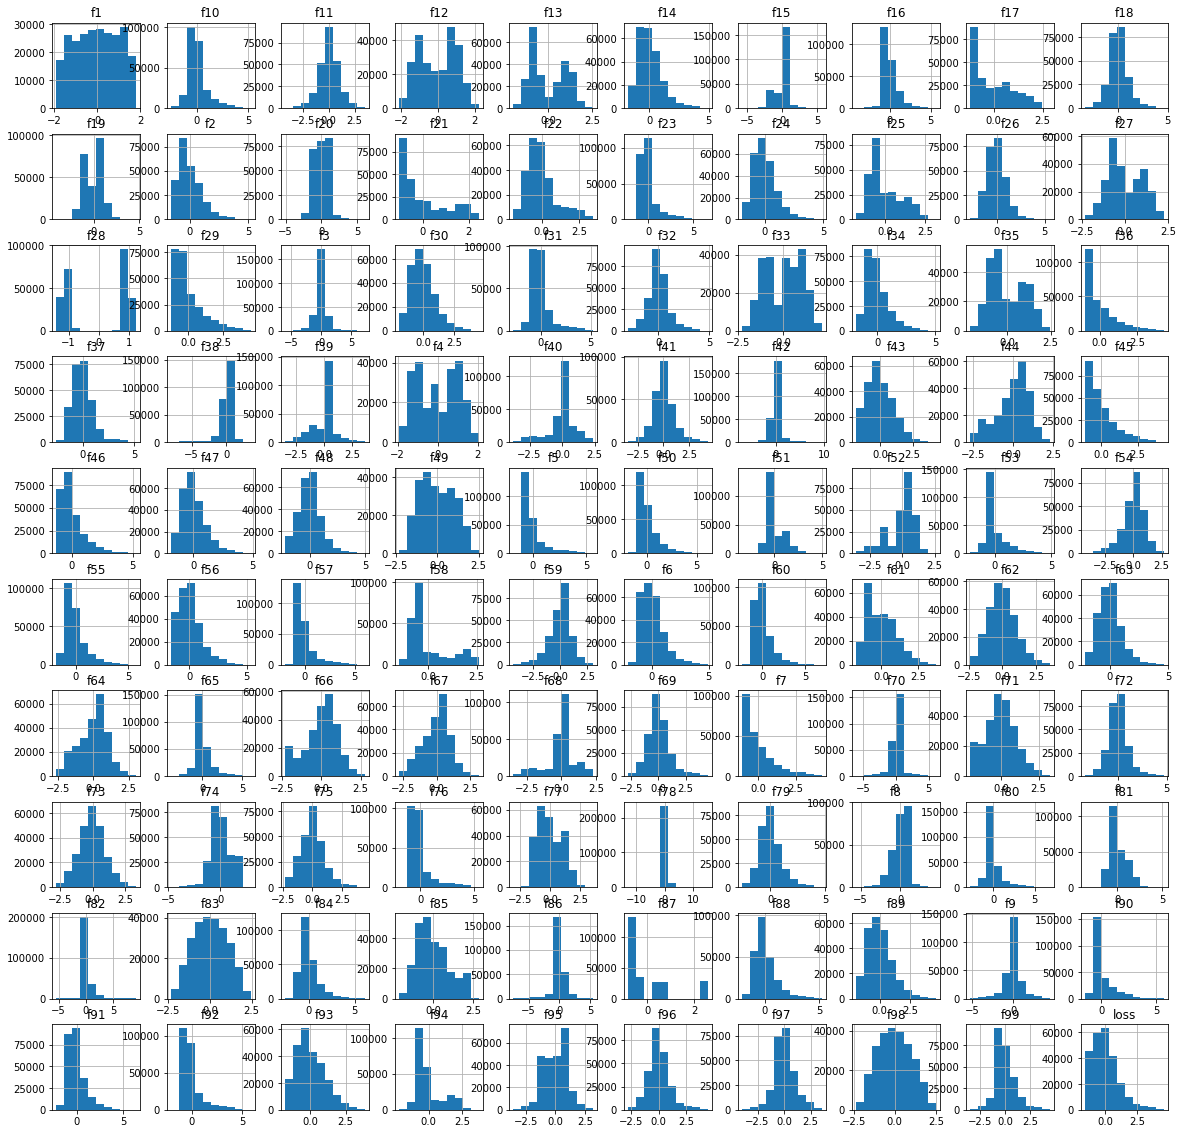

In [14]:
Normalised_dataframe = pd.DataFrame(X, columns=df.columns[2:])
Normalised_dataframe.hist(figsize = (20,20))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.1)

### Model Creation

In [24]:
xgb_params = {'n_estimators': 10000,
              'learning_rate': 0.010154255408501112,
              'subsample': 0.8406787739843629,
              'colsample_bytree': 0.7078557348809151,
              'max_depth': 7,
              'reg_lambda': 93.9874814976386,
              'reg_alpha': 33.26324929265035,
              'random_state': 42,
              'n_jobs': 4}

In [26]:
def train_and_test(X_train, X_test, y_train, y_test, regressor):
    if regressor == 'decision_tree':
        rgr = DecisionTreeRegressor(random_state=42)
    elif regressor == 'random_forest':
        rgr = RandomForestRegressor(random_state=42)
    elif regressor == 'gradient_boost':
        rgr = GradientBoostingRegressor(random_state=42)
    elif regressor == 'mlp':
        rgr = MLPRegressor(random_state=42, max_iter=200, learning_rate_init=1e-2)
    elif regressor == 'xgb':
        rgr = XGBRegressor(**xgb_params)
    
    start = timeit.default_timer()
    rgr.fit(X_train, y_train)
    stop = timeit.default_timer()
    
    y_pred = rgr.predict(X_test)
    time = stop - start
    
    if time >= 60 and time < 120:
        print(f"Time required: {(time)//60} minute {(time)%60} seconds")
    elif time >= 60:
        print(f"Time required: {(time)//60} minute {(time)%60} seconds")
    else:
        print(f"Time required: {time} seconds")
    
    return rgr, y_pred
        
    

In [23]:
def performance_measure(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    
    return rmse

In [18]:
# Evaluating decision tree regressor 
dt_rgr, y_pred = train_and_test(X_train, X_test, y_train, y_test, regressor='decision_tree')
dt_rmse = performance_measure(y_pred, y_test)
print(dt_rmse)

Time required: 1.0 minute 18.126878500000004 seconds
11.447086965686948


In [19]:
# Evaluating mlp regressor 
mlp_rgr, y_pred = train_and_test(X_train, X_test, y_train, y_test, regressor='mlp')
mlp_rmse = performance_measure(y_pred, y_test)
print(mlp_rmse)

Time required: 3.0 minute 55.62925059999998 seconds
8.24125681271303


C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [20]:
# Evaluating random forest regressor 
rf_rgr, y_pred = train_and_test(X_train, X_test, y_train, y_test, regressor='random_forest')
rf_rmse = performance_measure(y_pred, y_test)
print(rf_rmse)

Time required: 87.0 minute 2.3188324000002467 seconds
8.007430140063665


In [21]:
# Evaluating gradient boosting regressor 
gb_rgr, y_pred = train_and_test(X_train, X_test, y_train, y_test, regressor='gradient_boost')
gb_rmse = performance_measure(y_pred, y_test)
print(gb_rmse)

Time required: 14.0 minute 23.629971499999556 seconds
7.914939140363055


In [27]:
# Evaluating XGB regressor 
xgb_rgr, y_pred = train_and_test(X_train, X_test, y_train, y_test, regressor='xgb')
xgb_rmse = performance_measure(y_pred, y_test)
print(xgb_rmse)

Time required: 287.0 minute 18.327798300000723 seconds
7.8728024603727995


### Experimental Section

In [47]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [59]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Unidirectional deep LSTM model 
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256,return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[-1])))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(128,return_sequences=True))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.LSTM(64,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

# Bidirectional deep LSTM model
# model = tf.keras.Sequential()
# # Adding a Bidirectional LSTM layer
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True, dropout=0.5, input_shape=(X_train.shape[1], X_train.shape[-1]))))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, dropout=0.5)))
# model.add(tf.keras.layers.Dense(1))
# model.compile(loss='mse', optimizer='rmsprop')


history = model.fit(X_train_lstm, y_train, epochs=2, batch_size=32, validation_split=0.2,shuffle=False)

model.summary()

Epoch 1/4
5625/5625 [==============================] - 51s 9ms/step - loss: 63.9292 - val_loss: 62.2567
Epoch 2/4
5625/5625 [==============================] - 53s 9ms/step - loss: 63.2307 - val_loss: 62.2294
Epoch 3/4
5625/5625 [==============================] - 53s 9ms/step - loss: 63.1705 - val_loss: 62.1215
Epoch 4/4
5625/5625 [==============================] - 52s 9ms/step - loss: 62.9069 - val_loss: 62.1527
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 1, 256)            365568    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1, 128)            197120    
_________________________________________________________________
dropout_7 (Dropout)          (None

In [60]:
y_pred = model.predict(X_test_lstm)

In [61]:
lstm_rmse = performance_measure(y_pred, y_test)
print(lstm_rmse)

7.935552455844891
